<a href="https://colab.research.google.com/github/SCCSMARTCODE/Deep-Learning-00/blob/main/Cifar10/Cifar_10_RESNET_version2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.nn import functional as F
from torch import nn
from torch.optim import Adam
from torchvision.datasets import CIFAR10
import torchvision.transforms as tt
from torch.utils.data import random_split, DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from pprint import pprint

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"{device.type} is available")

cuda is available


In [3]:
class Cifar10CNN(nn.Module):

    def __init__(self):
        super(Cifar10CNN, self).__init__()

        self.conv1_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(128),

            # nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=1),
            # nn.ReLU(),
            # nn.BatchNorm2d(128),
        )

        self.residual1_layers = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )

        self.conv2_layers = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(512)

            # nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
            # nn.ReLU(),
            # nn.MaxPool2d(2),
            # nn.BatchNorm2d(512),
        )

        self.residual2_layers = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),

            nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),

            nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )

        self.conv3_layers = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(1024),

            nn.Conv2d(1024, 1024, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(1024)

            # nn.Conv2d(1024, 2048, kernel_size=3, padding=1, stride=1),
            # nn.ReLU(),
            # nn.MaxPool2d(2),
            # nn.BatchNorm2d(2048),
        )

        self.full_connected = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(1024, 64),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(64, 10),
        )

    def forward(self, input):
        out = self.conv1_layers(input)
        out = out + self.residual1_layers(out)
        out = self.conv2_layers(out)
        out = out + self.residual2_layers(out)
        out = self.conv3_layers(out)
        out = self.full_connected(out)
        return out

# Model instantiation and device transfer
model = Cifar10CNN()
model.to(device=device)


Cifar10CNN(
  (conv1_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (residual1_layers): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): BatchNo

In [4]:
dataset_path="/content/drive/MyDrive/Deep Learning/cifar_10"


transformation = tt.Compose([
    tt.ToTensor(),
    tt.Pad(3, padding_mode="reflect"),
    tt.RandomCrop(size=32),
    tt.RandomRotation(10),
    tt.RandomHorizontalFlip()
])


train_dataset = CIFAR10(root=dataset_path, transform=transformation, train=True)
test_dataset = CIFAR10(root=dataset_path, transform=transformation, train=False)

In [5]:
WEIGHT_DECAY=1e-4
MAX_LR=2e-3
EPOCHS=10




train_inputs, val_inputs = random_split(train_dataset, [45000, 5000])
train_dl = DataLoader(train_inputs, batch_size=512, shuffle=True, pin_memory=True, num_workers=2)
val_dl = DataLoader(val_inputs, batch_size=128)
loss_fn = F.cross_entropy
optim = Adam(model.parameters(), lr=0.0009, weight_decay=WEIGHT_DECAY)
lr_scheduler = OneCycleLR(optim, max_lr=MAX_LR, total_steps=EPOCHS*len(train_dl))

In [6]:
@torch.no_grad
def accuracy(val_dl):
    acc_count = 0
    data_points = 0
    for input, label in val_dl:
        input = input.to(device=device)
        label = label.to(device=device)
        _, index = torch.max(model(input), dim=1)
        acc_count += sum([1 for x, y in zip(index, label) if x == y])
        data_points += len(label)

    return acc_count/data_points


@torch.no_grad
def evaluate(val_dl):
    model.eval()
    losses = []
    for input, label in val_dl:
        input = input.to(device=device)
        label = label.to(device=device)
        output = model(input)
        loss = nn.CrossEntropyLoss()(output, label)
        losses.append(loss.item())

    loss = torch.mean(torch.tensor(losses))

    acc = accuracy(val_dl)
    return {"val_loss": loss, "val_acc": acc}


In [7]:
def train(epochs, model, train_dl, loss_fn, optim, val_dl, lr_scheduler):
    val_history = []
    training_loss_history = []
    for epoch in range(epochs):
        model.train()

        for inputs, labels in train_dl:
            batch_loss = []
            inputs = inputs.to(device=device)
            labels = labels.to(device=device)

            pred = model(inputs)
            loss = loss_fn(pred, labels)
            batch_loss.append(loss)
            loss.backward()
            optim.step()
            lr_scheduler.step()

            optim.zero_grad()

            # grad = model.named_parameters()
            # return grad


        loss_mean = torch.mean(torch.stack(batch_loss))
        training_loss_history.append(loss_mean)

        # validation stage
        validation_update = evaluate(val_dl)
        val_history.append(validation_update)
        torch.save(model.state_dict(), "/content/drive/MyDrive/Deep Learning/cifar_10/parameters-cnn_version2.pth")

        print(f"{epoch+1}/{epochs} Loss: {loss_mean} {validation_update}")


    return val_history, training_loss_history

In [8]:
output = train(EPOCHS, model, train_dl, loss_fn, optim, val_dl, lr_scheduler)

1/10 Loss: 1.4851547479629517 {'val_loss': tensor(1.4914), 'val_acc': 0.483}
2/10 Loss: 1.2828972339630127 {'val_loss': tensor(1.3280), 'val_acc': 0.5596}
3/10 Loss: 1.0860238075256348 {'val_loss': tensor(1.1687), 'val_acc': 0.6042}
4/10 Loss: 0.8469569087028503 {'val_loss': tensor(0.9594), 'val_acc': 0.666}
5/10 Loss: 0.8756997585296631 {'val_loss': tensor(0.8354), 'val_acc': 0.7174}
6/10 Loss: 0.7165172696113586 {'val_loss': tensor(0.6690), 'val_acc': 0.7706}
7/10 Loss: 0.5536722540855408 {'val_loss': tensor(0.5998), 'val_acc': 0.7962}
8/10 Loss: 0.5584132671356201 {'val_loss': tensor(0.5079), 'val_acc': 0.8276}
9/10 Loss: 0.4115431308746338 {'val_loss': tensor(0.4469), 'val_acc': 0.8502}
10/10 Loss: 0.469934344291687 {'val_loss': tensor(0.4468), 'val_acc': 0.854}


In [9]:
MAX_LR=5e-4


optim = Adam(model.parameters(), lr=0.00005, weight_decay=WEIGHT_DECAY)
lr_scheduler = OneCycleLR(optim, max_lr=MAX_LR, total_steps=EPOCHS*len(train_dl))

In [10]:
output1 = train(EPOCHS, model, train_dl, loss_fn, optim, val_dl, lr_scheduler)

1/10 Loss: 0.4017584025859833 {'val_loss': tensor(0.3802), 'val_acc': 0.869}
2/10 Loss: 0.5278711318969727 {'val_loss': tensor(0.4728), 'val_acc': 0.8506}
3/10 Loss: 0.4518710672855377 {'val_loss': tensor(0.5050), 'val_acc': 0.8252}
4/10 Loss: 0.481910765171051 {'val_loss': tensor(0.4968), 'val_acc': 0.839}
5/10 Loss: 0.4062426686286926 {'val_loss': tensor(0.4645), 'val_acc': 0.8494}
6/10 Loss: 0.2984062135219574 {'val_loss': tensor(0.4230), 'val_acc': 0.8664}
7/10 Loss: 0.2802327871322632 {'val_loss': tensor(0.3536), 'val_acc': 0.8802}
8/10 Loss: 0.21657401323318481 {'val_loss': tensor(0.3372), 'val_acc': 0.89}
9/10 Loss: 0.20734475553035736 {'val_loss': tensor(0.3058), 'val_acc': 0.8964}
10/10 Loss: 0.1591821014881134 {'val_loss': tensor(0.3013), 'val_acc': 0.9038}


In [11]:
MAX_LR=5e-5


optim = Adam(model.parameters(), lr=0.000005, weight_decay=WEIGHT_DECAY)
lr_scheduler = OneCycleLR(optim, max_lr=MAX_LR, total_steps=EPOCHS*len(train_dl))

In [12]:
output2 = train(EPOCHS, model, train_dl, loss_fn, optim, val_dl, lr_scheduler)

1/10 Loss: 0.17906786501407623 {'val_loss': tensor(0.1570), 'val_acc': 0.942}
2/10 Loss: 0.2261536866426468 {'val_loss': tensor(0.1553), 'val_acc': 0.9454}
3/10 Loss: 0.18268977105617523 {'val_loss': tensor(0.1590), 'val_acc': 0.9472}
4/10 Loss: 0.17537811398506165 {'val_loss': tensor(0.1725), 'val_acc': 0.9426}
5/10 Loss: 0.18715672194957733 {'val_loss': tensor(0.1611), 'val_acc': 0.9464}
6/10 Loss: 0.1303287297487259 {'val_loss': tensor(0.1702), 'val_acc': 0.9438}
7/10 Loss: 0.15556426346302032 {'val_loss': tensor(0.1599), 'val_acc': 0.9454}
8/10 Loss: 0.11307051032781601 {'val_loss': tensor(0.1528), 'val_acc': 0.95}
9/10 Loss: 0.1224793791770935 {'val_loss': tensor(0.1428), 'val_acc': 0.9452}
10/10 Loss: 0.12300608307123184 {'val_loss': tensor(0.1596), 'val_acc': 0.9464}


In [13]:
print(evaluate(val_dl))

{'val_loss': tensor(0.1575), 'val_acc': 0.9482}


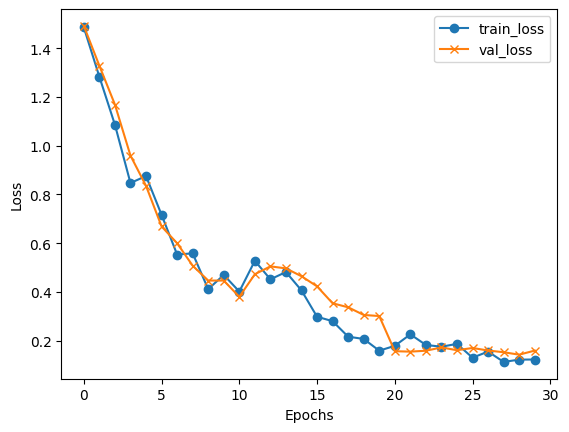

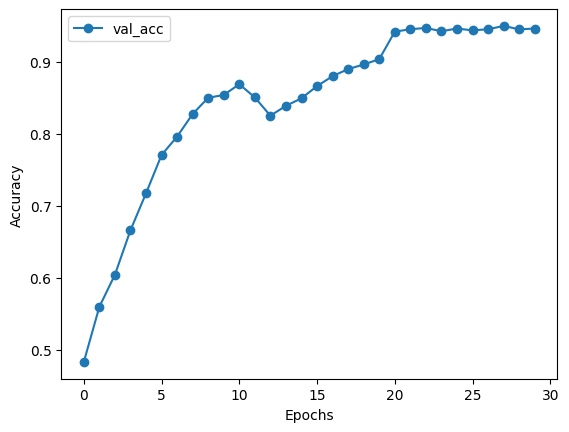

In [14]:
import torch
from matplotlib import pyplot as plt
import numpy as np

plt.figure(1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
test_loss = output[1]
val_loss = [x["val_loss"].cpu().numpy() for x in output[0]]
val_acc = [x["val_acc"] for x in output[0]]

for output in [output1, output2]:
    val_loss.extend([x["val_loss"].cpu().numpy() for x in output[0]])
    val_acc.extend([x["val_acc"] for x in output[0]])
    test_loss.extend(output[1])

plt.plot(np.array(torch.tensor(test_loss, device=torch.device("cpu"))), "-o", label="train_loss")
plt.plot(np.array(val_loss), "-x", label="val_loss")
plt.legend()

plt.figure(2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.plot(np.array(val_acc), "-o", label="val_acc")
plt.legend()

plt.show()